# Tortuosity HeatMap Generation Pipeline for Multiple Morphologies
This notebook generates heatmaps that visualize the tortuosity, the winding of paths between differently colored regions, for specified morphologies. It uses the py_graspi package in order to generate the graphs from morphology files, and to find the tortuosity between black and red regions and white and blue regions.

The following cell imports all the necessary modules as well as adds the 'src' path so we can access modules as necessary.

In [2]:
%matplotlib inline
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from py_graspi import graph as ig

sys.path.append(os.path.abspath('../../src'))

This cell defines a helper function that extracts the x,y,z, coordinates from the header line in the given morphology file.

In [ ]:
def find_coords(filename):
    """
        find coordinates of file

        Args:
            filename(string): path to file

        Returns:
            coords: x,y,x coords of file in a list.
        """
    with open(filename, "r") as file:
        header = file.readline().split(' ')
        dimX, dimY = int(header[0]), int(header[1])
        if len(header) < 3:
            dimZ = 1
        else:
            if int(header[2]) == 0:
                dimZ = 1
            else:
                dimZ = int(header[2])

        if dimZ > 1:
            # dimZ = dimX * dimY
            is_2d = False
        coords = [dimX, dimY, dimZ]
    return coords

This next function filters the given graph to create subgraphs where the edges are the same color or they are red or blue. This helps us set up to visualize the tortuosity paths between colored regions by grouping where those colored regions might be.

In [ ]:
def filterGraph(graph):
    keptEdges = [edge for edge in graph.get_edgelist()
                 if graph.vs[edge[0]]['color'] == graph.vs[edge[1]]['color']
                 or 'red' in {graph.vs[edge[0]]['color'], graph.vs[edge[1]]['color']}
                 or 'blue' in {graph.vs[edge[0]]['color'], graph.vs[edge[1]]['color']}]

    return graph.subgraph_edges(keptEdges, delete_vertices=False)

These two functions find and visualize the tortuosity between black to red vertices (BTR) and white to blue vertices (WTB).

In [ ]:
def find_BTR_tortuosity(g, is_2d, filename):
    """
        finds and visualizes the tortuosity of Black to Red vertices
        Args:
            g (ig.Graph): The input graph.
            is_2d(bool): true if 2D of false if otherwise
            filename(string): path to file

        Returns:
            No return but a visualization is created and displayed on screen.
        """
    numVertices = g.vcount()
    redVertex = g.vcount() - 2
    blackToRedList = []
    filteredGraph = filterGraph(g)
    idOfPixelIn1DArray, tort = read_BTR_file_and_extract_numbers(filename)
    #Calculate vertex frequencies
    vertex_frequency = [0] * numVertices
    for i in range(len(idOfPixelIn1DArray)):
        vertex_frequency[idOfPixelIn1DArray[i]] = tort[i]

    vertex_frequency = vertex_frequency[:-3]
    dimX,dimY,dimZ = coords = find_coords(filename)
    data_2d = np.array(vertex_frequency[:dimX * dimY]).reshape(dimY, dimX)
    # Create the heatmap
    #plt.rcParams.update({'font.size': 20})
    plt.title("Black to Red Tortuosity HeatMap")
    plt.imshow(data_2d, cmap='hsv', interpolation='nearest')
    plt.colorbar()  # Add a colorbar to show the values
    plt.show()

def find_WTB_tortuosity(g, is_2d, filename):
    """
        finds and visualizes the tortuosity of White to Blue vertices
        Args:
            g (ig.Graph): The input graph.
            is_2d(bool): true if 2D of false if otherwise
            filename(string): path to file

        Returns:
            No return but a visualization is created and displayed on screen.
        """
    numVertices = g.vcount()
    redVertex = g.vcount() - 2
    blueVertex = g.vcount() - 1
    whiteToBlueList = []
    idOfPixelIn1DArray, tort = read_WTB_file_and_extract_numbers(filename)
    #Calculate vertex frequencies
    vertex_frequency = [0] * numVertices
    for i in range(len(idOfPixelIn1DArray)):
        vertex_frequency[idOfPixelIn1DArray[i]] = tort[i]

    vertex_frequency = vertex_frequency[:-3]
    dimX,dimY,dimZ = coords = find_coords(filename)
    data_2d = np.array(vertex_frequency[:dimX * dimY]).reshape(dimY, dimX)

    # Create the heatmap
    #plt.rcParams.update({'font.size': 20})
    plt.title("White to Blue Tortuosity HeatMap")
    plt.imshow(data_2d, cmap='hsv', interpolation='nearest')
    plt.colorbar()  # Add a colorbar to show the values
    plt.show()

These two functions read the data from provided BTR or WTB files and extracts data from them.

In [3]:
# Define the function to read the file and extract the numbers
def read_BTR_file_and_extract_numbers(base_filename):
    """
        reads Black to Red Tortuosity ID file and extracts numbers needed from it
        Args:
            base_filename(string): path to file

        Returns:
            idOfPixelIn1DArray(list): list of id of pixel in 1D array
            tort(list): list of tortuosity, index matches that of idOfPixelIn1DArray
        """
    base_filename = os.path.basename(filename)
    base_filename = base_filename[:-4]
    file_path = f"../../tests/test_results/{base_filename}_IdTortuosityBlackToRed.txt"
    idOfPixelIn1DArray = []
    tort = []
    # Open the file in read mode
    with open(file_path, "r") as file:
        # Read each line in the file
        for line in file:
            # Split the line into a list of strings
            parts = line.split()
            # Extract the first and second numbers and convert them to appropriate types
            first_number = int(parts[0])
            second_number = float(parts[1])
            # Append the numbers to their respective lists
            idOfPixelIn1DArray.append(first_number)
            tort.append(second_number)

    return idOfPixelIn1DArray, tort

def read_WTB_file_and_extract_numbers(base_filename):
    """
        reads White to Black Tortuosity ID file and extracts numbers needed from it
        Args:
            base_filename(string): path to file

        Returns:
            idOfPixelIn1DArray(list): list of id of pixel in 1D array
            tort(list): list of tortuosity, index matches that of idOfPixelIn1DArray
        """
    base_filename = os.path.basename(filename)
    base_filename = base_filename[:-4]
    file_path = f"../../tests/test_results/{base_filename}_IdTortuosityWhiteToBlue.txt"
    # base_filename = base_filename[5:-4]
    # file_path = f"distances/{base_filename}-IdTortuosityWhiteToBlue.txt"
    idOfPixelIn1DArray = []
    tort = []

    # Open the file in read mode
    with open(file_path, "r") as file:
        # Read each line in the file
        for line in file:
            # Split the line into a list of strings
            parts = line.split()
            # Extract the first and second numbers and convert them to appropriate types
            first_number = int(parts[0])
            second_number = float(parts[1])
            # Append the numbers to their respective lists
            idOfPixelIn1DArray.append(first_number)
            tort.append(second_number)

    return idOfPixelIn1DArray, tort

From here on, each cell follows the same format to follow the pipeline for generating tortuosity heatmaps. The first line should contain the full path name for the morphology to be worked on. This can be changed as necessary.

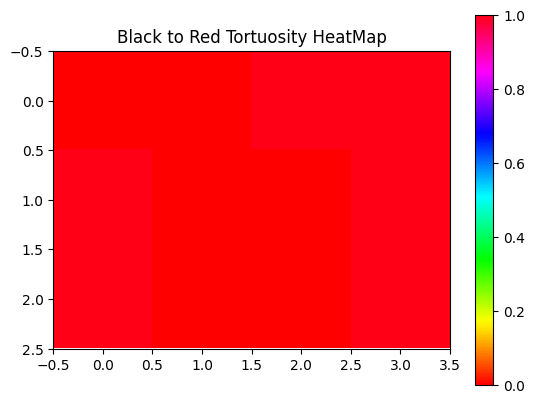

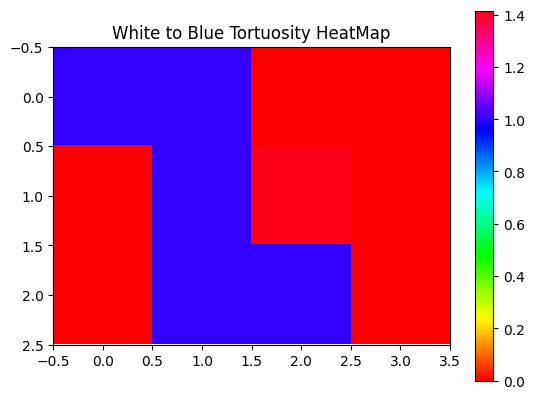

In [5]:
filename = "../../data/2phase/2D-morphologies/data/data_0.5_2.2_001900.txt"
graphData = ig.generateGraphAdj(filename)
find_BTR_tortuosity(graphData.graph, graphData.is_2D, filename)
find_WTB_tortuosity(graphData.graph, graphData.is_2D, filename)

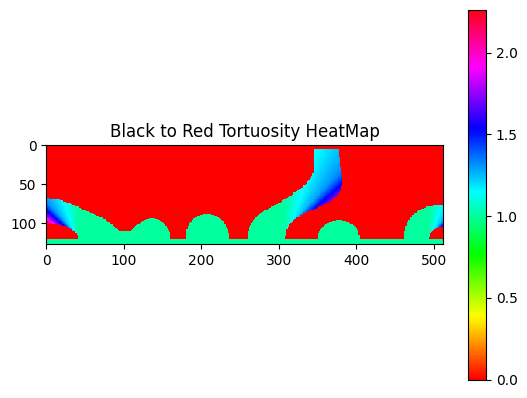

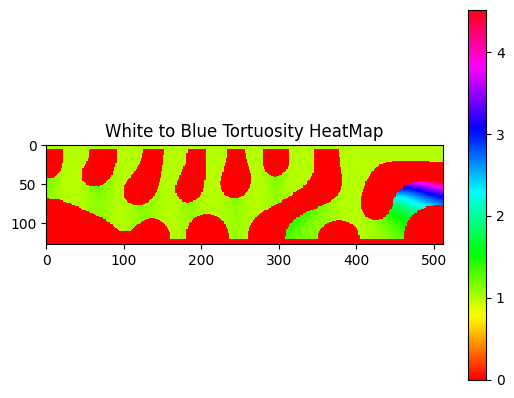

In [15]:
filename = "../../data/2phase/2D-morphologies/data/data_0.514_2.4_000220.txt"
graphData = ig.generateGraphAdj(filename)
find_BTR_tortuosity(graphData.graph, graphData.is_2D, filename)
find_WTB_tortuosity(graphData.graph, graphData.is_2D, filename)

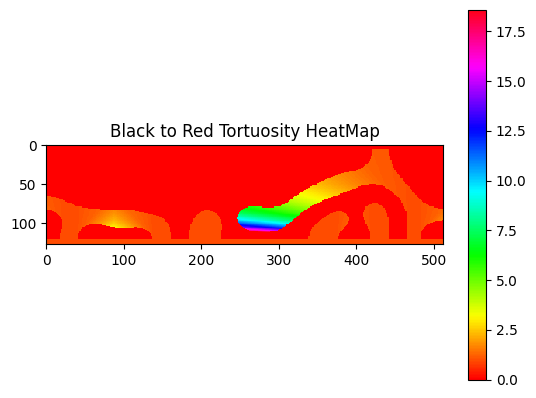

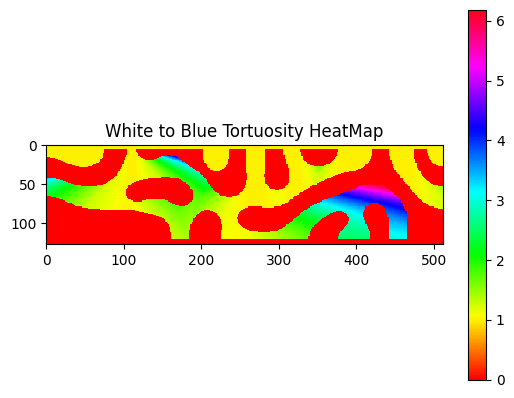

In [16]:
filename = "../../data/2phase/2D-morphologies/data/data_0.514_2.6_000080.txt"
graphData = ig.generateGraphAdj(filename)
find_BTR_tortuosity(graphData.graph, graphData.is_2D, filename)
find_WTB_tortuosity(graphData.graph, graphData.is_2D, filename)

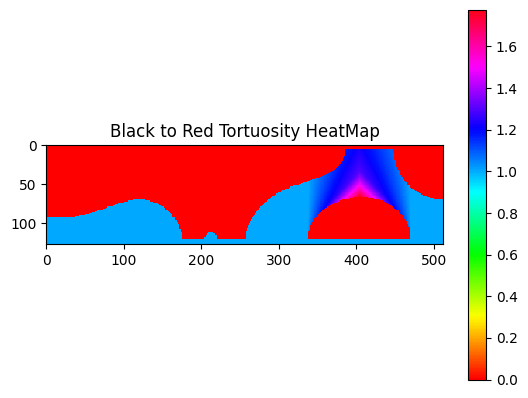

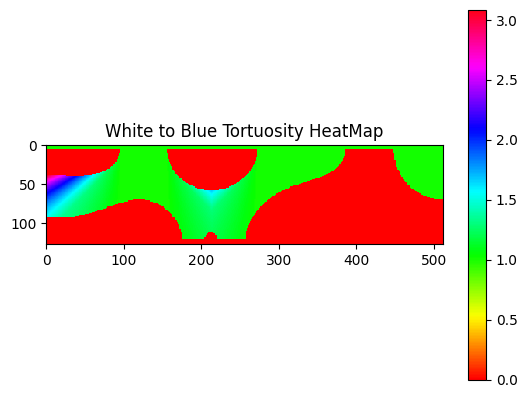

In [17]:
filename = "../../data/2phase/2D-morphologies/data/data_0.514_2.6_000980.txt"
graphData = ig.generateGraphAdj(filename)
find_BTR_tortuosity(graphData.graph, graphData.is_2D, filename)
find_WTB_tortuosity(graphData.graph, graphData.is_2D, filename)

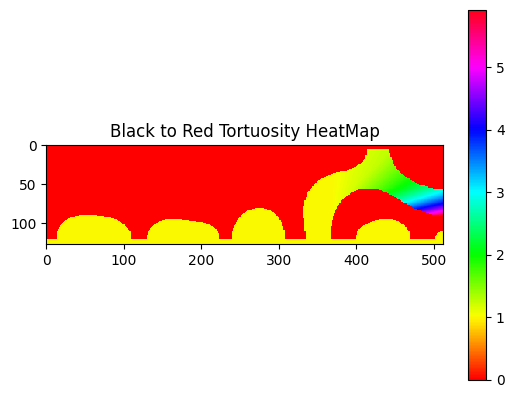

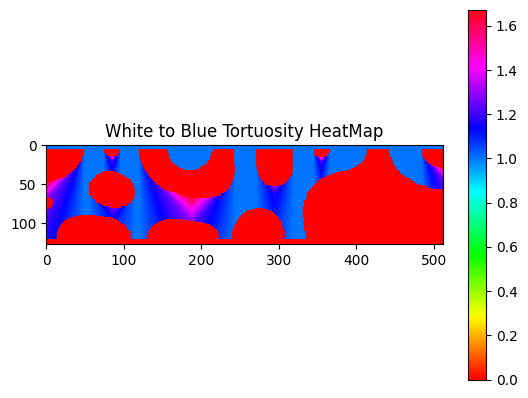

In [18]:
filename = "../../data/2phase/2D-morphologies/data/data_0.514_2.8_000200.txt"
graphData = ig.generateGraphAdj(filename)
find_BTR_tortuosity(graphData.graph, graphData.is_2D, filename)
find_WTB_tortuosity(graphData.graph, graphData.is_2D, filename)

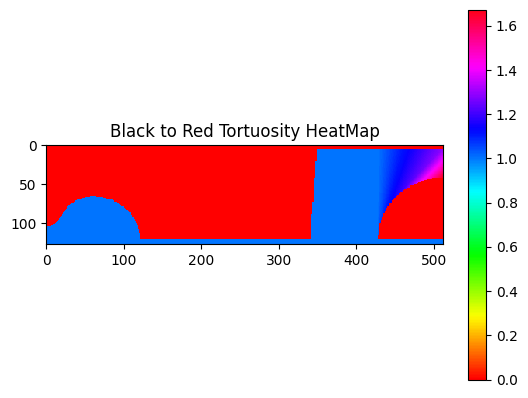

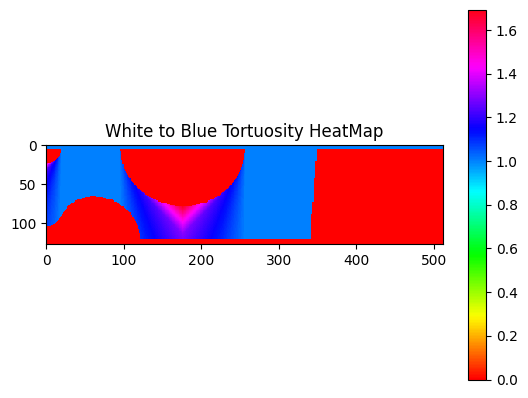

In [19]:
filename = "../../data/2phase/2D-morphologies/data/data_0.514_2.8_005540.txt"
graphData = ig.generateGraphAdj(filename)
find_BTR_tortuosity(graphData.graph, graphData.is_2D, filename)
find_WTB_tortuosity(graphData.graph, graphData.is_2D, filename)

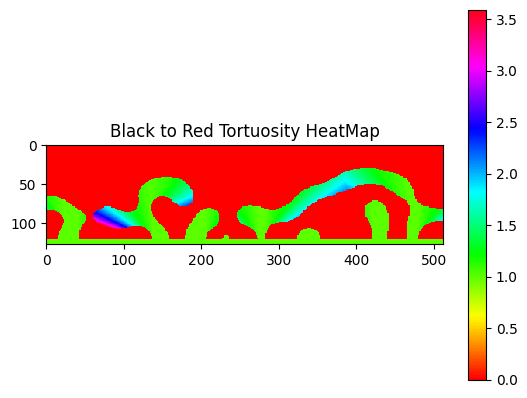

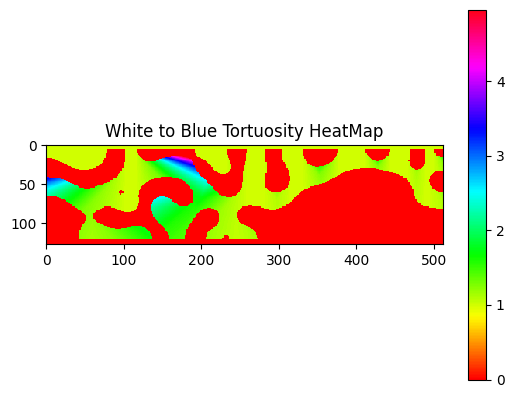

In [20]:
filename = "../../data/2phase/2D-morphologies/data/data_0.543_2.6_000060.txt"
graphData = ig.generateGraphAdj(filename)
find_BTR_tortuosity(graphData.graph, graphData.is_2D, filename)
find_WTB_tortuosity(graphData.graph, graphData.is_2D, filename)